# Data Cleaning & Quality Checks


In this notebook I perform the data cleaning and basic data quality checks for all the datasets used in this project. The goal is to transform the raw GeoJSON files into clean GeoDataFrames that can be used for exploratory data analysis and spatial analysis.

This includes:
- Basic preprocessing (column selection, data types, CRS)
- Consistency and validity checks
- Spatial validity checks
- Fixing or removing invalid records

The cleaned datasets are saved into the `data/processed/` folder and will be used in the EDA notebooks.

## 1. Source
The following datasets were downloaded from the Buenos Aires open data portal.

For more info about each dataset and their columns, visit the following links:


- **Dataset:** Paradas de Colectivo (GeoJSON)

    - **Link:** [Buenos Aires Data - Paradas de Colectivo][bus_stops]

- **Dataset:** Callejero (GeoJSON)

    - **Link:** [Buenos Aires Data - Callejero][callejero]

- **Dataset:** Comunas (GeoJSON)

    - **Link:** [Buenos Aires Data - Comunas][comunas]

- **Dataset** Barrios (GeoJSON)
    - **Link:** [Buenos Aires Data - Barios][barrios]

[bus_stops]: https://data.buenosaires.gob.ar/dataset/colectivos-paradas/resource/e9699a48-7189-499f-ab3b-d164fd7a1730
[callejero]: https://data.buenosaires.gob.ar/dataset/calles/resource/juqdkmgo-301-resource
[comunas]: https://data.buenosaires.gob.ar/dataset/comunas/resource/b0b627ac-5b47-4574-89ac-6999b63598ee
[barrios]: https://data.buenosaires.gob.ar/dataset/barrios/resource/1c3d185b-fdc9-474b-b41b-9bd960a3806e

## 2. Imports

In [139]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import box
from pathlib import Path
import sys

## 3. Loading Data

In [140]:
sys.path.append(str(Path.cwd().parent / "src"))
PROJECT_ROOT = Path.cwd().parent 
DATA_PATH = PROJECT_ROOT / "data" / "raw" 

DATA_PATH.exists()

True

In [141]:
stops_raw = gpd.read_file(DATA_PATH / "paradas-de-colectivo.geojson")

# Make a copy in order to leave the original file intact
stops = stops_raw.copy()
stops[["DIRECCION", "COMUNA", "BARRIO", "L1", "l1_sen", "L2", "geometry"]].head(3)

,DIRECCION,COMUNA,BARRIO,L1,l1_sen,L2,geometry
0,1524 DEFENSA,1,SAN TELMO,22,V,53,POINT (-58.37099 -34.62566)
1,1528 DEFENSA,1,SAN TELMO,29,I,None,POINT (-58.371 -34.62571)
2,"906 MITRE, BARTOLOME",1,SAN NICOLAS,105,V,None,POINT (-58.37966 -34.60722)


In [142]:
calles_raw = gpd.read_file(DATA_PATH / "callejero.geojson")
calles = calles_raw.copy()
calles[["nomoficial", "alt_izqini", "alt_izqfin", "comuna", "barrio", "geometry"]].head(3)

,nomoficial,alt_izqini,alt_izqfin,comuna,barrio,geometry
0,"CANTILO, INT.",0,0,13.0,Nuñez,"LINESTRING (-58.46219 -34.53452, -58.46267 -34..."
1,"LUGONES, LEOPOLDO AV.",0,0,13.0,Nuñez,"LINESTRING (-58.46515 -34.53465, -58.46496 -34..."
2,"PAZ, GRAL. AV.",2,300,13.0,Nuñez,"LINESTRING (-58.46561 -34.53507, -58.46577 -34..."


In [143]:
comunas_raw = gpd.read_file(DATA_PATH / "comunas.geojson")
comunas = comunas_raw.copy()
comunas.head(3)

,id,objeto,comuna,barrios,perimetro,area,geometry
0,1,COMUNA,1,"Constitucion, San Telmo, Monserrat, Retiro, Pu...",36351.19,17801036.28,"MULTIPOLYGON (((-58.34892 -34.61698, -58.34901..."
1,2,COMUNA,2,Recoleta,25965.02,6433391.77,"POLYGON ((-58.38039 -34.56847, -58.38037 -34.5..."
2,3,COMUNA,3,"San Cristobal, Balvanera",10486.26,6385992.08,"POLYGON ((-58.41192 -34.59801, -58.4103 -34.59..."


In [144]:
barrios_raw = gpd.read_file(DATA_PATH / "barrios.geojson")
barrios = barrios_raw.copy()
barrios.head(3)

,id,objeto,nombre,comuna,perimetro_,area_metro,geometry
0,1,BARRIO,Agronomia,15,6556.17,2122169.54,"POLYGON ((-58.47589 -34.59173, -58.47598 -34.5..."
1,2,BARRIO,Almagro,5,8537.90,4050752.63,"POLYGON ((-58.416 -34.59786, -58.4157 -34.5978..."
2,3,BARRIO,Balvanera,3,8375.82,4342280.68,"POLYGON ((-58.39294 -34.59964, -58.39277 -34.6..."


## 4. calles dataset cleaning

### 4.1 Columns
Let's have a look at the available columns. Only the columns required for name matching and spatial analysis are kept. Column names are then normalized to lowercase and snake_case for consistency.


In [145]:
calles.columns

Index(['id', 'codigo', 'nomoficial', 'alt_izqini', 'alt_izqfin', 'alt_derini',
       'alt_derfin', 'nomanter', 'nom_mapa', 'tipo_c', 'long', 'sentido',
       'observa', 'bicisenda', 'red_jerarq', 'tipo_ffcc', 'comuna', 'com_par',
       'com_impar', 'barrio', 'barrio_par', 'barrio_imp', 'geometry'],
      dtype='object')

Attributes related to traffic direction, or infrastructure are dropped, as they are not relevant for the current analysis. I will rename the **nom_oficial** column to **calle** for simplification.


In [146]:
from normalize_columns import normalize_columns
cols_to_keep = [
    "nomoficial", "barrio", "barrio_par", "barrio_imp",
    "comuna", "com_par", "com_impar", "geometry"
]

calles = calles[cols_to_keep].rename(columns={"nomoficial": "calle"})
calles.columns = normalize_columns(calles.columns)
calles.columns

Index(['calle', 'barrio', 'barrio_par', 'barrio_imp', 'comuna', 'com_par',
       'com_impar', 'geometry'],
      dtype='object')

### 4.2 Dtypes

In [147]:
calles.dtypes

calle           object
barrio          object
barrio_par      object
barrio_imp      object
comuna         float64
com_par        float64
com_impar      float64
geometry      geometry
dtype: object

Let's convert the columns **comuna**, **com_par** and **com_impar** to integers (communes are integers):

In [148]:
cols_to_convert = ["comuna","com_par","com_impar"]
for col in cols_to_convert:
    calles[col] = pd.to_numeric(calles[col], errors="coerce").astype('Int64')

calles[cols_to_convert].dtypes

comuna       Int64
com_par      Int64
com_impar    Int64
dtype: object

### 4.3 String normalization

In [149]:
from normalize_strings import normalize_strings
cols_to_norm = ["calle", "barrio", "barrio_par", "barrio_imp"]

for col in cols_to_norm:
    calles[col] = calles[col].apply(
        lambda x: normalize_strings(x)
    )

### 4.4 Data Quality

Percentage of missing values:

In [150]:
calles.isna().mean() * 100

calle         0.000000
barrio        5.409887
barrio_par    0.275344
barrio_imp    0.278473
comuna        5.409887
com_par       0.275344
com_impar     0.278473
geometry      0.000000
dtype: float64

Most columns show almost no missing values. The only exceptions are barrio and comuna, with about 5.4% missing values. This is expected, since many street segments are shared between two neighborhoods or communes. In those cases, the information is stored separately for even and odd sides of the street. There are no missing geometries, so the dataset is safe to use for spatial analysis.

### 4.5 Spatial Validity

Let's start by checking that the GeoDataFrames have the EPSG: 4326 CRS, then all the remaining gdf must be the same: 

In [151]:
calles.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Geometry types and bounding boxes are going to be inspected as basic spatial sanity checks to ensure that datasets contain the expected geometries and cover the expected geographic area. In particular, coordinates are expected to fall approximately within the following bounds:
- Latitude between -35 and -34
- Longitude between -59 and -58

In [152]:
calles["geometry"].geom_type.value_counts()

LineString    31960
Name: count, dtype: int64

In [153]:
calles.total_bounds

array([-58.5324417 , -34.70574495, -58.34190732, -34.52947415])

### 4.6 Aggregating street segments

Streets are stored as many small segments, which is great for mapping but not very convenient for analysis. Here I group all segments by street name, merging their geometries and keeping track of all the neighborhoods and communes they pass through. This gives me a cleaner, street-level view of the data

In [154]:
from shapely.ops import unary_union

def unique_values(series):
    return sorted(set(series.dropna()))

calles_agg = (
    calles
    .groupby("calle")
    .agg({
        "barrio_par": unique_values,
        "barrio_imp": unique_values,
        "com_par": unique_values,
        "com_impar": unique_values,
        "geometry": lambda l: unary_union(l)
    })
    .reset_index()
)

calles_agg["barrios"] = (calles_agg["barrio_par"] + calles_agg["barrio_imp"]).apply(lambda x: sorted(set(x)))

calles_agg["comunas"] = (calles_agg["com_par"] + calles_agg["com_impar"]).apply(lambda x: sorted(set(x)))

calles_agg = calles_agg.drop(columns=["barrio_par", "barrio_imp", "com_par", "com_impar"])

In [155]:
calles_agg = gpd.GeoDataFrame(
    calles_agg,
    geometry="geometry",
    crs=calles.crs
)

In [156]:
calles_agg.head()

,calle,geometry,barrios,comunas
0,1 DE AGOSTO DIA DE LA PACHAMAMA,"LINESTRING (-58.46192 -34.67274, -58.46162 -34...",[VILLA LUGANO],[8]
1,10 DE DICIEMBRE DE 1983,"LINESTRING (-58.39172 -34.64781, -58.39252 -34...",[BARRACAS],[4]
2,10 DE DICIEMBRE DE 1983 PLAZA DE LOS CONGRESOS,"LINESTRING (-58.39142 -34.60925, -58.39148 -34...",[MONSERRAT],[1]
3,10 DE ENERO DE 2001,"LINESTRING (-58.46297 -34.67407, -58.46257 -34...",[VILLA LUGANO],[8]
4,10 DE OCTUBRE DE 1996,"MULTILINESTRING ((-58.40121 -34.6595, -58.4019...",[BARRACAS],[4]


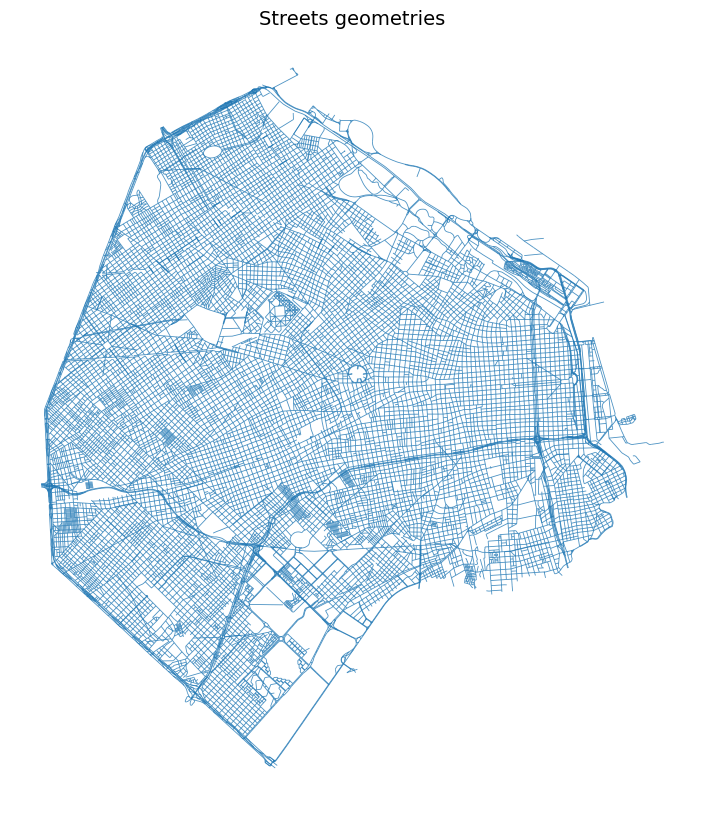

In [157]:
ax = calles_agg.plot(
    figsize=(10, 10),
    linewidth=0.6,
    alpha=0.8
)

ax.set_title("Streets geometries", fontsize=14)
ax.set_axis_off()


A quick map visualization for a sanity check. The streets look continuous and well merged, which confirms that the aggregation by street name worked as expected.

### 4.7 Exporting 

GeoPackage is used instead of GeoJSON because it is more compact, faster to read, and better suited for processed geospatial layers.

In [158]:
PROCESSED_PATH = PROJECT_ROOT / "data" / "processed"
output_path = PROCESSED_PATH / "calles.gpkg"

calles_agg.to_file(output_path, layer="calles", driver="GPKG")